![Activation Functions](images/activation.png)

# makemore: part 3 s2, How to solve bad initialization for much complex/deeper NN

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

/Users/jiangliu/miniconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Following Kaiming Init to improve Normalization
1. Not quite important now due to other modern innovated techniques

In [14]:
emb_size = 10
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_size), generator=g)
## for hidden layer, 100 to 300 neurons to make it more complex
W1 = torch.randn((block_size*emb_size, 200), generator=g) * (5/3) / (emb_size * block_size)**0.5 ##* 0.2 # scale down W1
b1 = torch.randn(200, generator=g) * 0.01 # try to make activations close to zero
W2 = torch.randn((200, 27), generator=g) * 0.01 # scale down W2
b2 = torch.randn(27, generator=g) * 0 # try to make logits close to zero
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad_()

11897


tensor(0.0090) tensor(0.9877)
tensor(0.0003) tensor(0.9984)


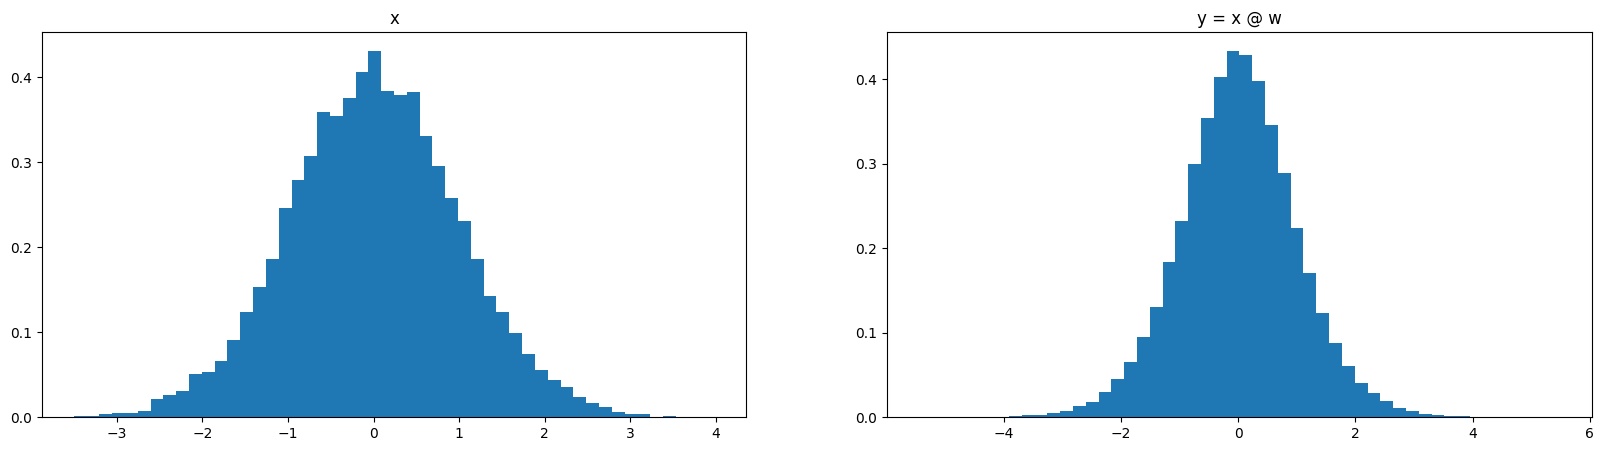

In [15]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
# *5 -> more extrem standard deviation
# *0.2 -> 0.6 deviation
y = x @ w # how to scale it to make it preserve the distribution like x sampled from Guassian
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121, title='x')
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122, title='y = x @ w')
plt.hist(y.view(-1).tolist(), bins=50, density=True);
         

### Initialization Notes 
1. [kaiming init 2015](https://arxiv.org/pdf/1502.01852.pdf) 
2. [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html)

In [12]:
(torch.randn(10000) * 0.2).std()

tensor(0.1992)

In [13]:
(5/3) / (emb_size * block_size)**0.5 ## gain / sqrt(fan_in), fan_in = emb_size * block_size

0.3042903097250923

## Batch Normalization
1. [Reducing Internal Covariate Shift 2015](https://arxiv.org/pdf/1502.03167.pdf)

In [26]:
# TODO: 41.11
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  # break

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1001
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


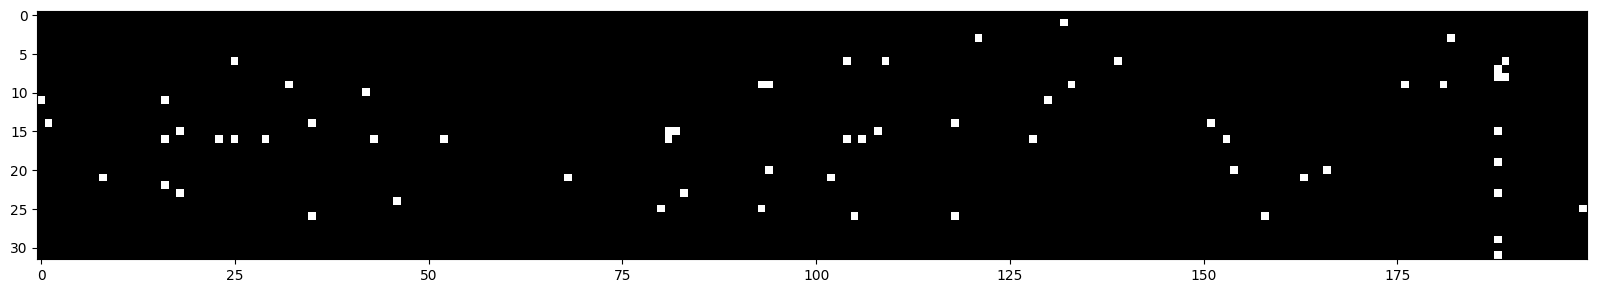

In [22]:
plt.figure(figsize=(20,10))
## to see how many values that are close to tanh flat region
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
## white for true, black for false
## Too many whites, entire white column dead neurons

In [16]:
logits[0] # on quite extreme values

tensor([-0.0405,  0.1421, -0.0283,  0.0199,  0.0547, -0.0121, -0.0171,  0.0049,
         0.0016,  0.0383,  0.1011, -0.0390,  0.0050, -0.1152, -0.0352,  0.0168,
        -0.0065, -0.0920, -0.1353, -0.0063,  0.0800,  0.0880,  0.0685, -0.0652,
        -0.0892,  0.0727,  0.0656], grad_fn=<SelectBackward0>)

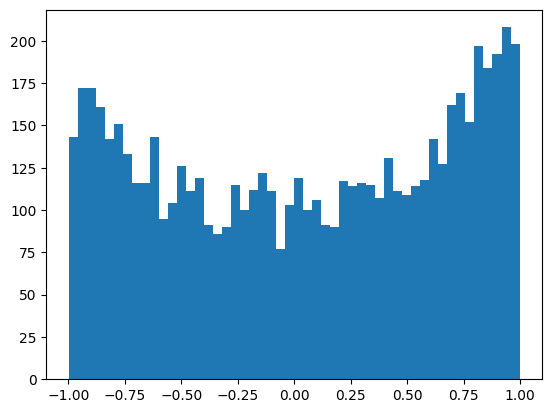

In [23]:
h.shape # 32x200
plt.hist(h.view(-1).tolist(), bins=50); # quite a bit of saturation

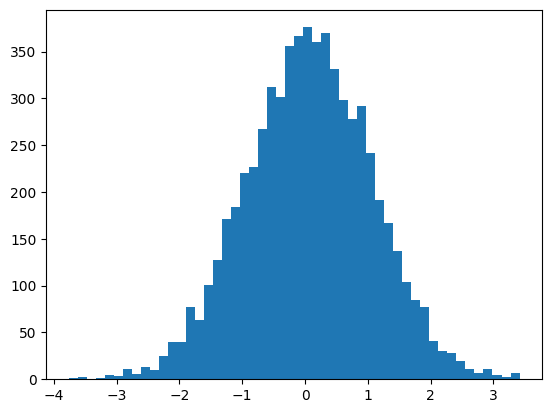

In [24]:
# prevalue before tanh activation
plt.hist(hpreact.view(-1).tolist(), bins=50); # quite a bit of saturation

In [11]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

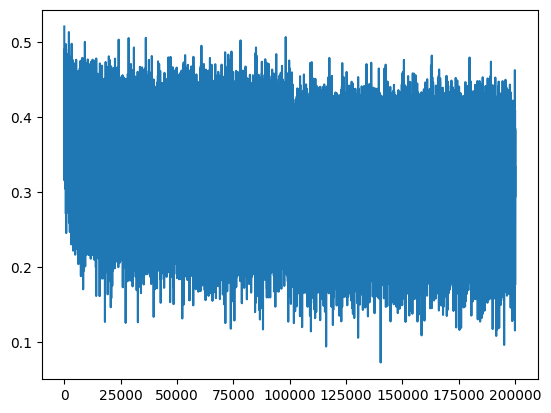

In [27]:
plt.plot(lossi)

In [28]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # （N, block_size, n_embd）
    embcat = emb.view(emb.shape[0], -1) # concat into ()
    h = torch.tanh(embcat @ W1 + b1) # （N, n_hidden）
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.0355966091156006
dev 2.1026785373687744


In [ ]:
# loss log

# orginal loss
train 2.1245384216308594
val 2.168196439743042

# after fixing softmax confidently wrong:
train 2.07
val 2.13

# after fixing tanh layer too staturated at init
train 2.0355966091156006
val 2.1026785373687744

In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+10) # for reproducibility

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        ## forward pass the neural net
        emb = C[torch.tensor(context)] # (1, block_size, emb_size)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, 1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break   
        
    print(''.join(itos[i] for i in out)) # convert indices to characters


carpah.
amille.
khy.
mili.
taty.
skanden.
jazhuen.
den.
art.
kaqui.
nellara.
chaiir.
kaleigh.
ham.
jore.
quinn.
salin.
alian.
quinterri.
jaryn.


In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056840419769287
